In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [ ]:
trades = pd.read_csv(r"csv files\historical_data.csv")
sentiment = pd.read_csv(r"csv files\fear_greed_index.csv")

trades.columns, sentiment.columns


(Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
        'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
        'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
        'Timestamp'],
       dtype='object'),
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object'))

In [14]:
trades['time'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
)

trades['date'] = trades['time'].dt.date


In [15]:
sentiment['time'] = pd.to_datetime(
    sentiment['timestamp'],
    unit='s'
)

sentiment['date'] = sentiment['time'].dt.date


In [17]:
merged = trades.merge(
    sentiment,
    left_on='date',
    right_on='date',
    how='inner'
)

merged.rename(columns={'classification': 'sentiment'}, inplace=True)

merged.to_csv("merged_data.csv", index=False)


In [25]:
print(merged.columns.tolist())


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'time_x', 'date', 'timestamp', 'value', 'sentiment', 'time_y']


In [26]:
merged['abs_size'] = merged['Size Tokens'].abs()  # use 'Size USD' if you prefer USD volume

# Group by date and sentiment
daily_metrics = merged.groupby(['date', 'sentiment']).agg(
    total_volume=('abs_size', 'sum'),
    total_pnl=('Closed PnL', 'sum'),
    trade_count=('Account', 'count')
).reset_index()

# Save results
daily_metrics.to_csv("daily_trader_metrics.csv", index=False)

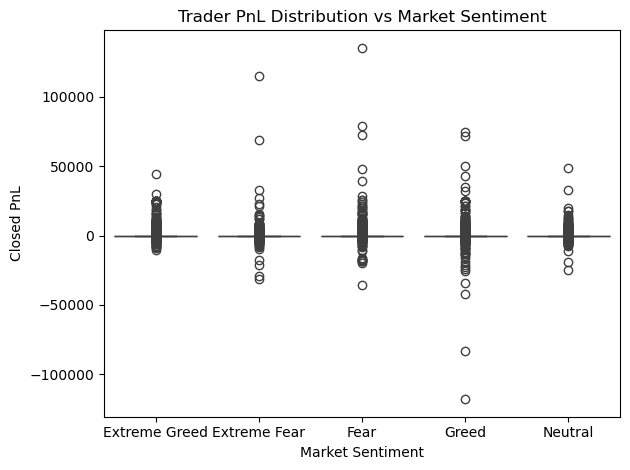

In [ ]:
# Boxplot of trader PnL vs sentiment
sns.boxplot(data=merged, x='sentiment', y='Closed PnL')
plt.title("Trader PnL Distribution vs Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.tight_layout()  # ensures labels/titles are not cut off
plt.savefig(r"outputs\pnl_vs_sentiment.png")
plt.show()

In [32]:
# Example leverage proxy (Size USD / Execution Price)
merged['leverage'] = merged['Size USD'] / merged['Execution Price']


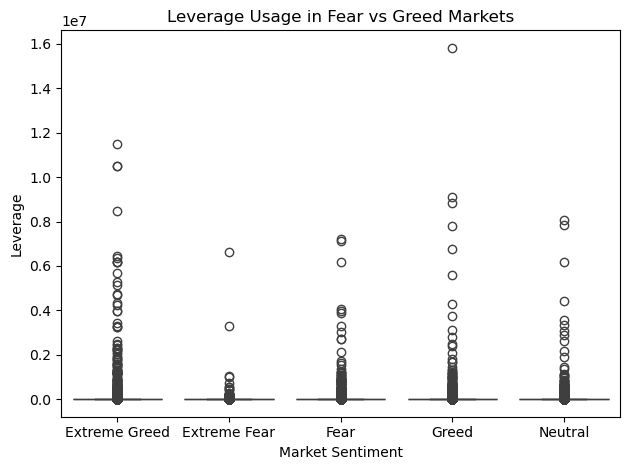

In [ ]:
# Boxplot of leverage vs sentiment
sns.boxplot(data=merged, x='sentiment', y='leverage')
plt.title("Leverage Usage in Fear vs Greed Markets")
plt.xlabel("Market Sentiment")
plt.ylabel("Leverage")
plt.tight_layout()
plt.savefig(r"outputs\leverage_vs_sentiment.png")
plt.show()

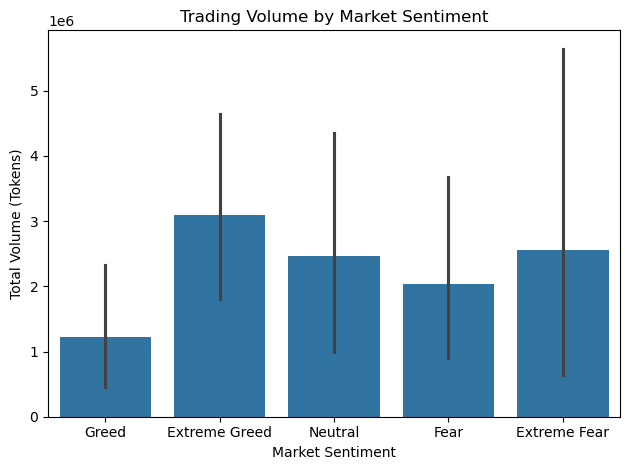

In [ ]:
# Barplot of total volume by sentiment
sns.barplot(data=daily_metrics, x='sentiment', y='total_volume')
plt.title("Trading Volume by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Total Volume (Tokens)")
plt.tight_layout()
plt.savefig(r"outputs\volume_vs_sentiment.png")
plt.show()

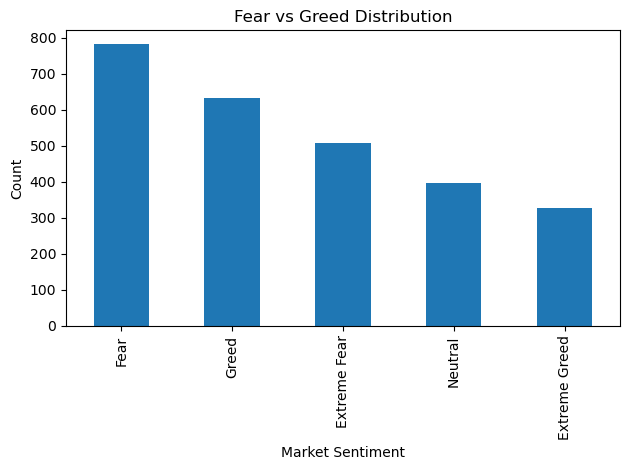

In [ ]:
# Bar plot of sentiment distribution
sentiment['classification'].value_counts().plot(kind='bar')
plt.title("Fear vs Greed Distribution")
plt.xlabel("Market Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(r"outputs\sentiment_distribution.png")
plt.show()

In [43]:
# Group by sentiment and calculate mean only for numeric columns
numeric_cols = ['total_volume', 'total_pnl', 'trade_count']
daily_metrics.groupby('sentiment')[numeric_cols].mean().round(2)


,total_volume,total_pnl,trade_count
sentiment,,,
Extreme Fear,2561722.64,52793.59,1528.57
Extreme Greed,3098473.43,23817.29,350.81
Fear,2033582.35,36891.82,679.53
Greed,1228990.32,11140.57,260.64
Neutral,2465546.77,19297.32,562.48
